In [1]:
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

import theano as th
th.config.warn.round=False

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option("display.width",110)
pd.set_option("display.max_columns",12)
np.set_printoptions(linewidth=110, edgeitems=6, suppress=True)

/Users/graham/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


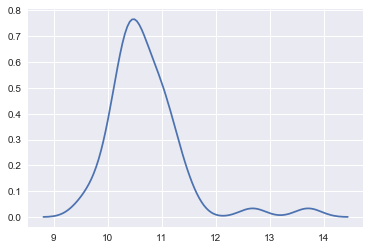

In [2]:
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45, 52.34,
55.65, 51.49, 51.86, 63.43, 53.00, 56.09, 51.93, 52.31, 52.33, 57.48, 57.44,
55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73, 51.94, 54.95, 50.39,
52.91, 51.5, 52.68, 47.72, 49.73, 51.82, 54.99, 52.84, 53.19, 54.52, 51.46,
53.73, 51.61, 49.81, 52.42, 54.3, 53.84, 53.16]).astype(np.float32)
data = data / 5
_ = sns.kdeplot(data)

### General Experimenting

In [3]:
# general experimenting from PYMC3 API quickstart

with pm.Model() as model:
    mu = pm.Normal('mu', mu=10, sd=50)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    plus_2 = pm.Deterministic('mu plus 2', mu + 2) # rubbish variable
    xx = pm.Normal('xx', mu=0, sd=1, shape=5)      # rubbish variable
    obs = pm.Normal('obs', mu=mu, sd=sigma, observed=data)

model.basic_RVs, model.observed_RVs, model.free_RVs, model.deterministics
model.named_vars
#model.logp({'mu': 0})
mu.random(size=3)
xx.random(size=3)

([mu, sigma_interval__, xx, obs],
 [obs],
 [mu, sigma_interval__, xx],
 [sigma, mu plus 2])

{'mu': mu,
 'mu plus 2': mu plus 2,
 'obs': obs,
 'sigma_interval__': sigma_interval__,
 'xx': xx}

array([ 63.16600188, -27.24410449,  51.51900157])

array([[ 1.00429481,  0.68865006,  0.31358545,  0.04424124,  0.0001265 ],
       [-0.08459837, -1.34881419, -0.21398466, -0.80136547, -0.60226863],
       [ 1.71403634, -0.64230422, -0.71737332,  0.52491549,  0.11147331]])

In [4]:
# live plotting of inference (commented out)

#%matplotlib notebook 

with model: # model using NUTS (default) sampler and ADVI
    trace = pm.sample(5000, njobs=4, n_init=50000) #, live_plot=True, refresh_every=500, roll_over=1000)
    advi  = pm.fit(random_seed=1).sample(50000)
#%matplotlib inline

trace['mu'].shape
trace.nchains
trace.get_values('mu', chains=1).shape

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 63.191:  52%|█████▏    | 26249/50000 [00:02<00:02, 8744.90it/s]
Convergence archived at 26900
Interrupted at 26,900 [53%]: Average Loss = 121.22
Average Loss = 136.14: 100%|██████████| 10000/10000 [00:00<00:00, 10183.57it/s]
Finished [100%]: Average Loss = 135.81


(20000,)

4

(5000,)

In [6]:
pm.raftery_lewis(x, q, r, s=.95, epsilon=.001, verbose=1)

AttributeError: module 'pymc3' has no attribute 'raftery_lewis'

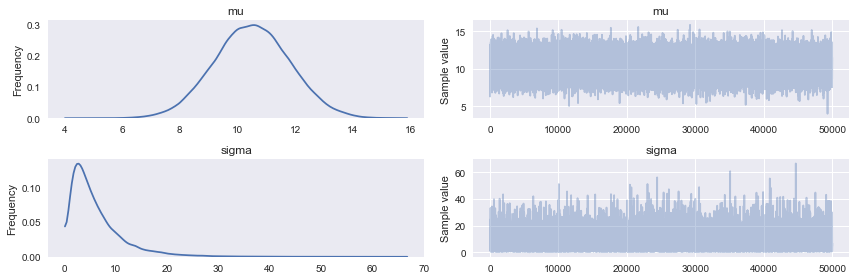

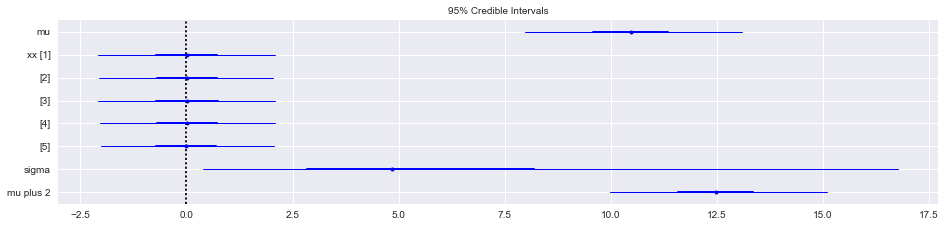

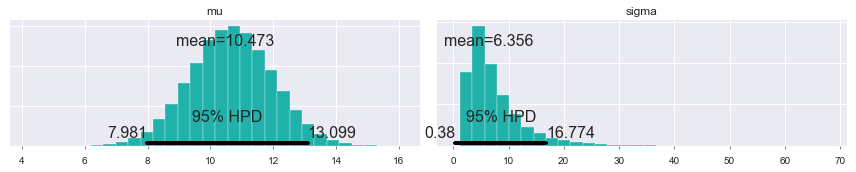

In [50]:
_ = pm.traceplot(advi, varnames=['mu', 'sigma'])
_ = plt.show()

_ = plt.figure(figsize=(15,3))
_ = pm.forestplot(advi)
_ = plt.show()

_ = pm.plot_posterior(advi, color='lightseagreen', varnames=['mu','sigma'])

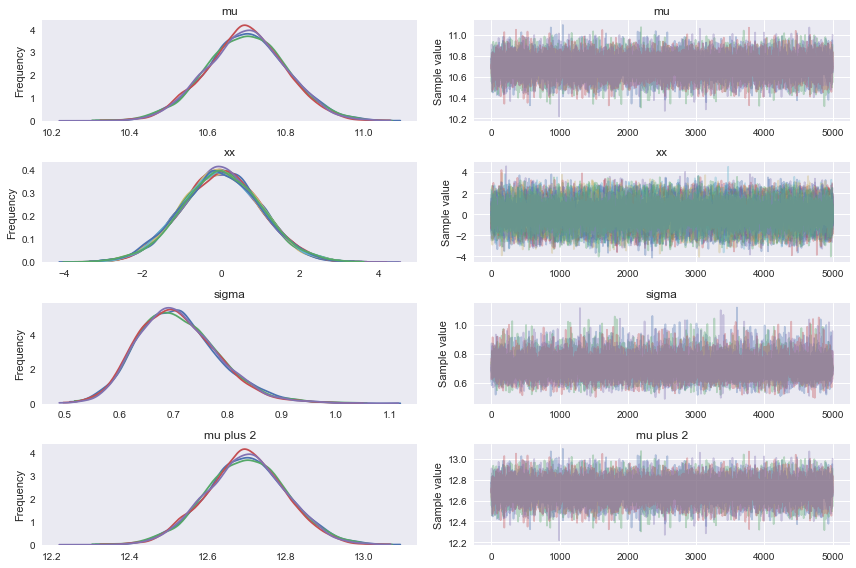

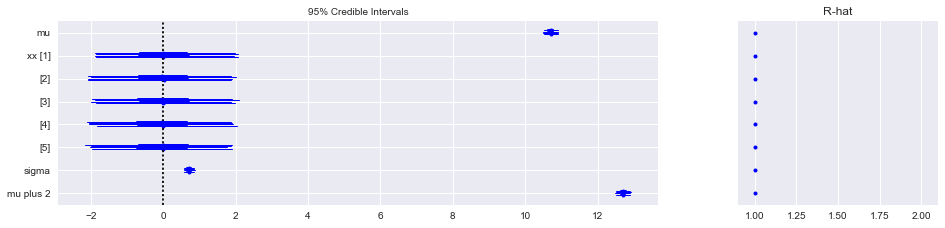

{'mu': 0.99996553119972709,
 'mu plus 2': 0.99996553119972709,
 'sigma': 1.0000794787040157,
 'sigma_interval__': 1.0000764361185821,
 'xx': array([ 0.99991549,  0.99997433,  1.00003062,  0.99997898,  0.99994731])}

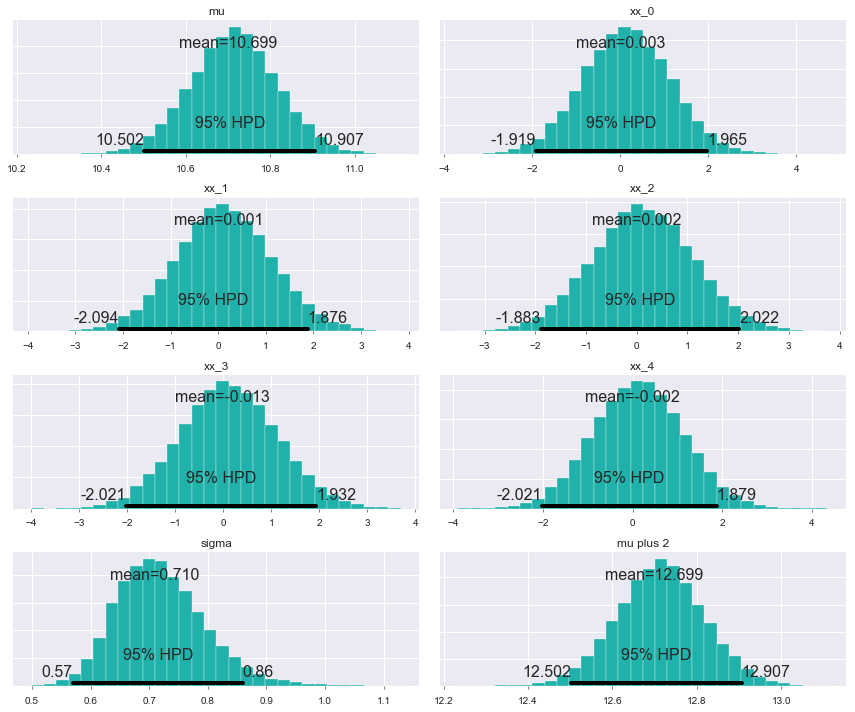

In [51]:
_ = pm.traceplot(trace)
_ = plt.show()

_ = plt.figure(figsize=(15,3))
_ = pm.forestplot(trace)
_ = plt.show()

pm.gelman_rubin(trace)

_ = pm.plot_posterior(trace, color='lightseagreen')

100%|██████████| 1000/1000 [00:16<00:00, 62.10it/s]
/Users/graham/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


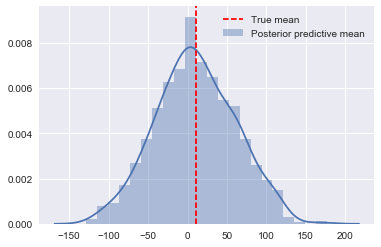

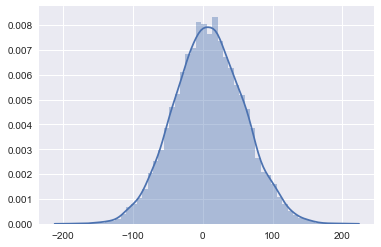

In [54]:
with model:
    post_pred = pm.sample_ppc(trace, samples=1000)
    
post_pred['obs'].shape

ax = sns.distplot(post_pred['obs'], label='Posterior predictive mean')
_ = ax.axvline(data.mean(), color='r', ls='--', label='True mean')
_ = ax.legend()
_ = plt.show()

_ = sns.distplot(mu.random( size=10000))

### Finding mean and standard deviation

In [7]:
%%time

np.random.seed(1)
with pm.Model() as m1:
    mu = pm.Uniform('mu', min(data), max(data))
    sigma = pm.HalfNormal('sigma', sd=10)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data) # a student T might be better here
    
    start = pm.find_MAP()
    step = pm.NUTS() # pm.Metropolis()
    trace_m1 = pm.sample(4000, step=step, start=start, njobs=4)
    
trace_m1b = trace_m1[500:]   

         Current function value: 54.391045
         Iterations: 8
         Function evaluations: 99
         Gradient evaluations: 87


100%|██████████| 4500/4500 [00:06<00:00, 736.84it/s]


CPU times: user 10.2 s, sys: 1.02 s, total: 11.2 s
Wall time: 49.4 s


/Users/graham/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


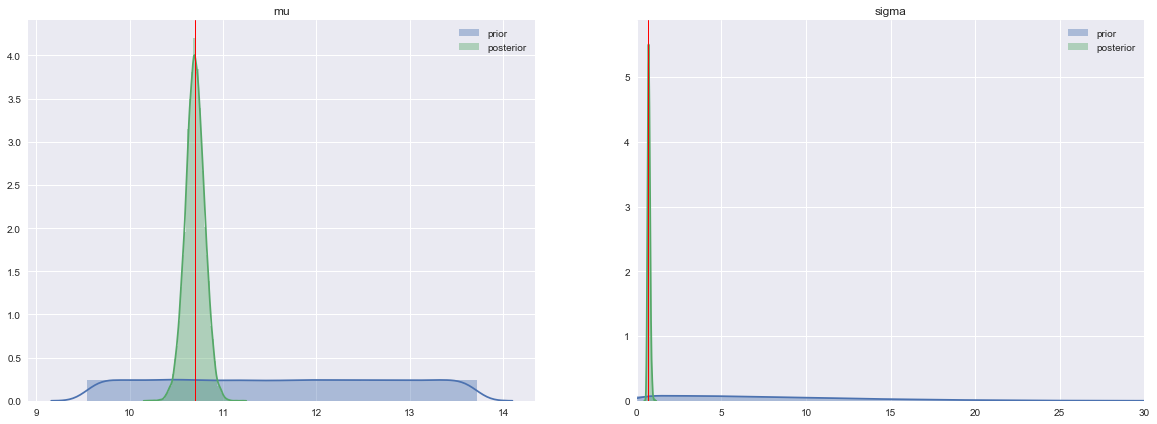

In [8]:
# show priors
_ = plt.figure(figsize=(20,7))

_ = plt.subplot(121)
_ = plt.title('mu')
_ = sns.distplot(mu.random(size=100000), label='prior')
_ = sns.distplot(trace_m1b.mu, label='posterior')
_ = plt.axvline(x=data.mean(), lw=1, color='r')
_ = plt.legend()

_ = plt.subplot(122)
_ = plt.title('sigma')
_ = sns.distplot(sigma.random(size=100000), label='prior')
_ = sns.distplot(trace_m1b.sigma, label='posterior')
_ = plt.axvline(x=data.std(), lw=1, color='r')
_ = plt.legend()
_ = plt.xlim(0,30)

#_ = plt.hist(sigma.random(size=100000), bins=100, normed=True, alpha=0.7, label='prior')
#_ = plt.hist(trace_m1b.sigma, bins=100, normed=True, alpha=0.7, label='posterior')
#_ = plt.hist(mu.random(size=100000), bins=100, normed=True, alpha=0.7, label='prior')
#_ = plt.hist(trace_m1b.mu, bins=100, normed=True, alpha=0.7, label='posterior')

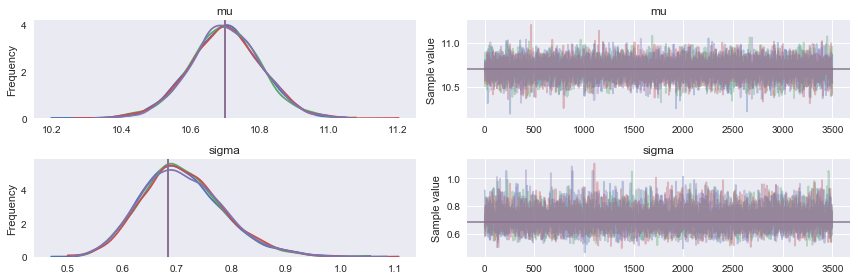

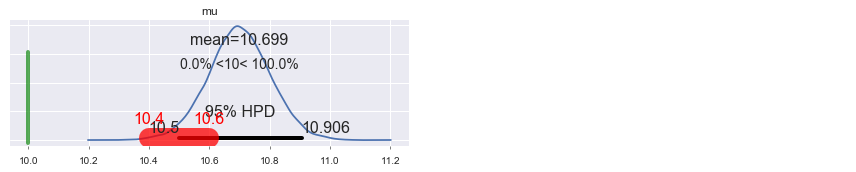

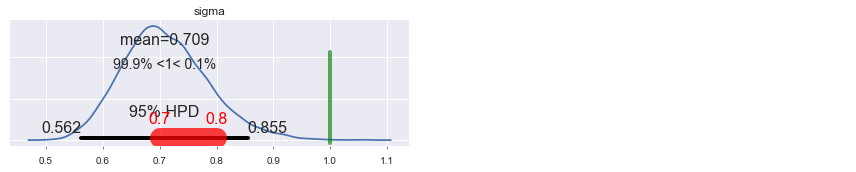

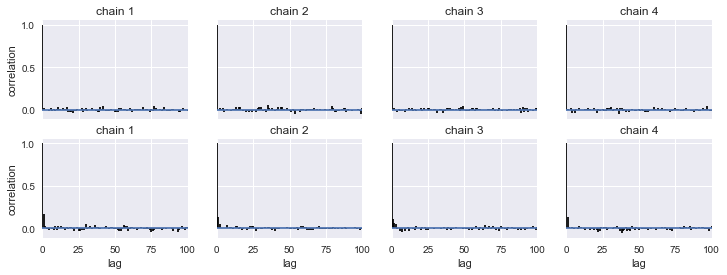

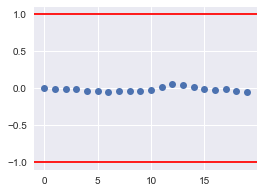

In [10]:
# show all relevant plots

_ = pm.traceplot(trace_m1b, lines={'mu': data.mean(), 'sigma': data.std()})

_ = pm.plot_posterior(trace_m1b, varnames=['mu'], kde_plot=True, rope=[10.4,10.6], ref_val=11)
_ = pm.plot_posterior(trace_m1b, varnames=['sigma'], kde_plot=True, rope=[0.7, 0.8], ref_val=1)

_ = pm.autocorrplot(trace_m1b)

_ = plt.figure(figsize=(4,3))
_ = plt.plot(pm.geweke(trace_m1b['mu'])[:,1], 'o')
_ = plt.axhline(1, c='red'); _ = plt.axhline(-1, c='red')
_ = plt.gca().margins(0.05)

In [43]:
# show all relevant diagnostics
pm.diagnostics.gelman_rubin(trace_m1b)
pm.diagnostics.effective_n(trace_m1b)

pm.df_summary(trace_m1b)
pd.DataFrame(data).describe().T

{'mu': 1.0000526506579144,
 'mu_interval_': 1.0000592552896899,
 'sigma': 1.0005980191434252,
 'sigma_log_': 1.0006139668936609}

{'mu': 9253.0, 'mu_interval_': 9189.0, 'sigma': 6380.0, 'sigma_log_': 6459.0}

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu,53.501238,0.496864,0.004870,52.527270,54.489587
sigma,3.541994,0.375928,0.004542,2.861996,4.312026


,count,mean,std,min,25%,50%,75%,max
0,48.0,53.496458,3.456198,47.72,51.5825,52.875,54.96,68.58


100%|██████████| 2000/2000 [00:14<00:00, 141.76it/s]
/Users/graham/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


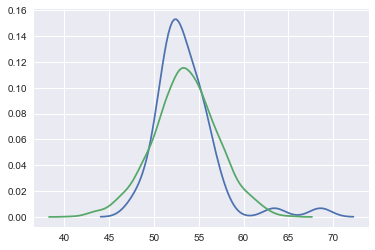

In [44]:
# generate posterior samples
with m1:
    ppc_m1b = pm.sample_ppc(trace_m1b, samples = 2000)
    
samples = ppc_m1b['y'][:,0]

_ = sns.kdeplot(data)
_ = sns.kdeplot(samples)

In [ ]:
# demo of sampling from prior (omit the observed keyword)
with pm.Model() as prior_context:
    sigma = pm.Gamma('gamma', alpha=2.0, beta=1.0)
    mu = pm.Normal('mu', mu=0, sd=sigma)
    trace = pm.sample(5000, step=pm.Metropolis())
_ = pm.traceplot(trace)   


### Linear Regression

In [ ]:
ans = sns.load_dataset('anscombe') 
x_2 = ans[ans.dataset == 'II']['x'].values 
y_2 = ans[ans.dataset == 'II']['y'].values 
x_2 = x_2 -x_2.mean() 
y_2 = y_2 -y_2.mean() 
#plt.scatter(x_2, y_2) 
#plt.xlabel('$x$', fontsize=16) 
#plt.ylabel('$y$', fontsize=16, rotation=0)

In [ ]:
np.random.seed(1)
with pm.Model() as model_poly:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=1)
    beta2 = pm.Normal('beta2', mu=0, sd=1)
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)
    mu = alpha + beta1 * x_2 + beta2 * x_2**2
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_2)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_poly = pm.sample(3000, step=step, start=start)

In [ ]:
_ = pm.traceplot(trace_poly)
_ = pm.plot_posterior(trace_poly, kde_plot=True)

In [ ]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['alpha'].mean() + trace_poly['beta1'].mean() * x_p + trace_poly['beta2'].mean() * x_p**2
_ = plt.scatter(x_2, y_2)
_ = plt.xlabel('$x$', fontsize=16)
_ = plt.ylabel('$y$', fontsize=16, rotation=0)
_ = plt.plot(x_p, y_p, c='r')

## German Tank Problem with PYMC3

In [4]:
tanks = np.array([10, 256, 202, 97]).astype(np.int32)
tanks

array([ 10, 256, 202,  97], dtype=int32)

In [5]:
m = tanks.mean()
s = tanks.std()
m,s

m+2*s

(141.25, 94.924641163398661)

331.09928232679732

In [6]:
# statistically optimal formula
max(tanks) + max(tanks) / len(tanks) - 1

319.0

In [7]:
import scipy.stats
stats.norm.ppf(0.96943389677160008)
stats.norm.cdf(1.8725380240735363)

1.8725380240735361

0.96943389677160008

In [24]:
#P(N∣tanks)∝ P(tanks∣N) * P(N)

with pm.Model() as tank_m:
    N = pm.DiscreteUniform("N", lower=tanks.max(), upper=10000) # define prior
    tank_obs = pm.DiscreteUniform("tank_r", lower=0, upper=N, observed=tanks) # define likelihood
    tank_r = pm.sample(10000, njobs=4)
    tank_r = tank_r[2000:] 

Assigned Metropolis to N
INFO:pymc3:Assigned Metropolis to N
100%|██████████| 10500/10500 [00:01<00:00, 6708.26it/s]



N:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  389.196          200.428          5.123            [256.000, 718.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  258.000        285.000        327.000        415.000        905.000



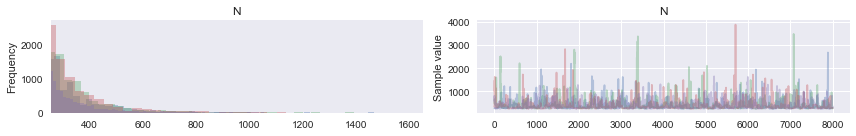

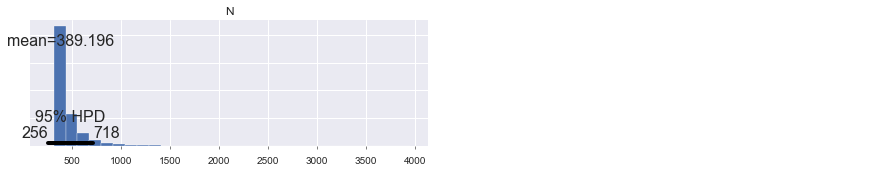

In [25]:
_ = pm.traceplot(tank_r)
_ = pm.plot_posterior(tank_r, kde_plot=False)
pm.summary(tank_r)

## German Tank Problem with Pystan

In [18]:
import pystan

ocode = """
data {
    int<lower=1> M;  // number of serial numbers observed
    real tanks[M];       // serial numbers
}
parameters {
    real<lower=max(tanks)> N;
}
model {
    N ~ uniform(max(tanks), 10000);  // P(N)
    tanks ~ uniform(0, N);           // P(D|N)
}
"""

data = {'tanks': tanks, 'M': len(tanks)}
fit = pystan.stan(model_code=ocode, data=data, init='init_r', iter=100000, warmup=1000, chains=4)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_17dd69bef31927148438092177f52297 NOW.


Inference for Stan model: anon_model_17dd69bef31927148438092177f52297.
4 chains, each with iter=100000; warmup=1000; thin=1; 
post-warmup draws per chain=99000, total post-warmup draws=396000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
N    384.06    0.39 211.49 258.18 281.73 322.49 406.33 877.64 287637    1.0
lp__ -19.47  2.2e-3   0.81 -21.77 -19.67 -19.16 -18.95 -18.89 137715    1.0

Samples were drawn using NUTS at Wed May 31 11:37:26 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

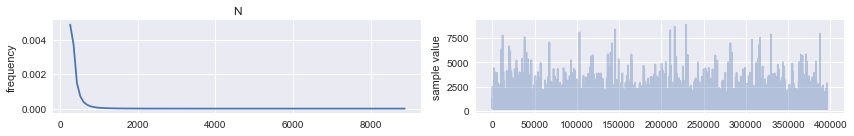

384.06184373628361

In [19]:
fig = fit.plot()
fig.set_size_inches((12, 2))

plt.tight_layout()
plt.show()

fit.extract()['N'].mean()

## Estimate Upper Limit of array of random numbers

In [20]:
# generate N random numbers

max_num = 246
num_range = np.arange(max_num) + 1

sample_np = np.random.choice(num_range, int(max_num * 0.05) ) # take a 5% sample from overall
sample_np

sample = th.shared(sample_np) # so can use same model with different data

array([158, 236, 141,  25,  48, 189,  26,  75, 179,  70, 141,  65])

In [21]:
with pm.Model() as rand_m:
    N = pm.DiscreteUniform("N", lower=sample.max(), upper=max_num*5) # define prior
    tank_obs = pm.DiscreteUniform("tank_r", lower=0, upper=N, observed=sample) # define likelihood

In [22]:
with rand_m:
    start = {'N': max_num*2}
    rand_r = pm.sample(50000, start=start, njobs=4 )

Assigned Metropolis to N
INFO:pymc3:Assigned Metropolis to N
100%|██████████| 50500/50500 [00:10<00:00, 4800.98it/s]



N:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  258.941          25.416           0.267            [236.000, 309.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  236.000        242.000        251.000        267.000        328.000



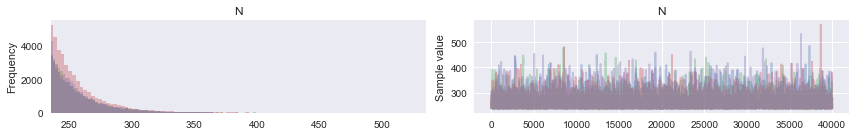

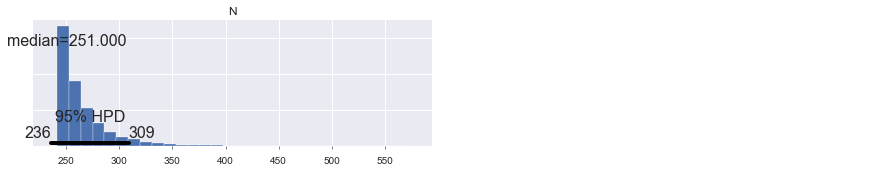

In [26]:
rand_r = rand_r[5000:] 
_ = pm.traceplot(rand_r)
_ = pm.plot_posterior(rand_r, kde_plot=False,point_estimate='median')
pm.summary(rand_r)